## Before we start  


1. Enable live module changes

*NOTE*
This is a code draft used to generate plots for paper: Toward Explainable NILM: Real-Time Event-Based NILM Framework for High-Frequency Data

**The final polished version will be uploaded upon acceptance of the paper.**

In [1]:
%reload_ext autoreload
%autoreload 2

2. Include common libraries

In [2]:
from tqdm import tqdm
from pathlib import Path
from scipy.signal import resample
from collections import defaultdict

import os
import re
import random
import pandas as pd
import numpy as np
# import scienceplots
import warnings
import matplotlib.pyplot as plt

In [3]:
FONT_SIZE = 16

warnings.filterwarnings('ignore')

4. Set random seed for reproducibility

In [4]:
RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

## Preprocessing PLAID dataset 

In this section, we read and pre-process the submetered and aggregated data from the PLAID dataset.

In [5]:
from readers import PLAID

Define paths to the datasets

In [6]:
PLAID_DIR = Path('<YOUR PATH HERE>')

# Waveforms
submetered_path = PLAID_DIR / "submetered_new"
aggregated_path = PLAID_DIR / "aggregated"

# Meta-data
meta_submetered_path = PLAID_DIR / 'metadata_submetered.json'
meta_aggregated_path = PLAID_DIR / "metadata_aggregated.json"

Define data readers

In [7]:
submetered_reader = PLAID(submetered_path, meta_submetered_path)
aggregated_reader = PLAID(aggregated_path, meta_aggregated_path)

In [8]:
from utils import read_signatures

# signatures = read_signatures(submetered_reader)

In [9]:
from utils import sync_recordings

# signatures = sync_recordings(signatures, window_size=10, outlier_thresh=0.1)

In [10]:
from utils import get_roi

I_ON = 0.05
I_RUNNING_MIN = 0.1
# ROI = get_roi(signatures, I_ON, I_RUNNING_MIN)

In [11]:
# assert all([abs(i).max(1).min() > I_RUNNING_MIN for _, i, *_ in ROI])

In [12]:
from utils import split_if_more

N_CYCLES = 60
# ROI = split_if_more(ROI, N_CYCLES)

In [13]:
from utils import assume_v

V_RMS = 120
# ROI = assume_v(ROI, V_RMS)

In [14]:
from utils import drop_noisy

P_MIN = 10
# ROI = drop_noisy(ROI, P_MIN)

In [15]:
# assert all([(v * i).mean() > P_MIN for v, i, *_ in ROI])

In [16]:
from utils import drop_correlated

X_THRESH = 1e-4
# ROI = drop_correlated(ROI, X_THRESH)

In [17]:
# _, i, fs, _, device, locs = random.choice(ROI)

# t = np.linspace(0, i.shape[0] * i.shape[1] / fs, i.shape[0] * i.shape[1])

# plt.plot(t, i.ravel(), color='blue')
# plt.ylabel('Current (A)')
# plt.xlabel('Time (s)')
# # plt.legend(bbox_to_anchor=(0.5, -0.3), loc='lower center', ncol=2)
# plt.show()

In [18]:
# import itertools as it

# # set(list(it.chain(*[[x['type'] for x in v['appliances']]
# #            for _, v in aggregated_reader.metadata])))
# [[x for x in v['appliances']]
#            for _, v in aggregated_reader.metadata]

In [19]:
from utils import get_submetered, split_by_ncomponents

signatures0 = read_signatures(aggregated_reader)
signatures0 = sync_recordings(signatures0, window_size=10, outlier_thresh=0.1)
# ROI0 = split_by_ncomponents(signatures0)
# ROIx = get_submetered(ROI0)

# ROIx = split_if_more(ROIx, N_CYCLES)
# ROIx = assume_v(ROIx, V_RMS)
# ROIx = drop_noisy(ROIx, P_MIN)
# ROIx = drop_correlated(ROIx, X_THRESH)

  0%|          | 0/575 [00:00<?, ?it/s]

100%|██████████| 575/575 [00:06<00:00, 86.60it/s] 


In [20]:
from scipy.spatial.distance import cdist


def f1_score(ground_truth, predicted, proximity=1):
    D = cdist(ground_truth[:, None], predicted[:, None])
    D_filtered = np.array([np.any(row) for row in D < proximity])

    TP = (D_filtered).sum()
    FP = len(predicted) - TP
    FN = len(ground_truth) - TP

    PR = (TP / (TP + FP)) if (TP + FP) > 0 else 0
    RE = (TP / (TP + FN)) if (TP + FN) > 0 else 0
    F1 = (2 * PR * RE) / (PR + RE) if (PR + RE) > 0 else 0

    return F1


from numba import njit

from numba import njit
import numpy as np


@njit
def run(data, threshold=3, window_size=10):
    left_window = np.zeros(window_size)
    detected_indices = []
    window_count = 0

    for i in range(len(data)):
        if window_count < window_size:
            left_window[window_count] = data[i]
            window_count += 1
        else:
            for j in range(1, window_size):
                left_window[j - 1] = left_window[j]
            left_window[-1] = data[i]

        if window_count == window_size:
            mu_L = np.mean(left_window)
            sigma_L = np.std(left_window)

            if i + 1 < len(data):
                z = (data[i + 1] - mu_L) / sigma_L
                if abs(z) > threshold:
                    detected_indices.append(i + 1)
                    window_count = 0 

    return np.array(detected_indices)

In [21]:
from sklearn.preprocessing import LabelEncoder

ROI0 = split_by_ncomponents(signatures0)
ROI1 = get_submetered(ROI0)

y1 = np.stack([y for *_, y, _ in ROI1])
enc = LabelEncoder()
y1 = enc.fit_transform(y1)

100%|██████████| 575/575 [00:00<00:00, 30980.32it/s]


In [22]:
D1 = enc.classes_

In [23]:
X1 = np.concatenate([i for _, i, *_ in ROI1])
P1 = np.concatenate([(v * i).mean(keepdims=True) for v, i, *_ in ROI1])
reps = np.concatenate([[len(i)] for _, i, *_ in ROI1])
y1 = np.repeat(y1, reps)
P1 = np.repeat(P1, reps)[:, None]
Zh = np.fft.rfft(X1, axis=1, norm='forward')
amplitudes = np.abs(Zh)
phases = np.angle(Zh)
print(amplitudes.shape, P1.shape)
n_low = 11
n_a_low = 2
X1h = np.concatenate(
    (
        amplitudes[:, :n_a_low],
        # np.log(amplitudes[:, :n_low] + 1e-9),
        # np.log(amplitudes[:, n_low:].mean(1, keepdims=True) + 1e-9),
        # np.sin(phases[:, 1:n_low]),
        np.cos(phases[:, 1:n_low]),
        np.cos(phases[:, n_low:]).mean(1, keepdims=True),
        # phases[:, n_low:].mean(1, keepdims=True),
    ),
    axis=-1)
from sklearn.decomposition import PCA

pca = PCA(whiten=True)

# X1h = np.concatenate((X1h, X1.std(1, keepdims=True), pca.fit_transform(X1)),
#                      axis=1)
print(X1h.shape)

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Prefit
# q = np.random.randint(len(X1h), size=500)
# m = XGBClassifier()
# m.fit(X1h[q], y1[q])

(164510, 251) (164510, 1)
(164510, 13)


In [24]:
# from xgboost import plot_importance
import matplotlib.pyplot as plt

# imps = m.feature_importances_
# # feature_mask = (imps > np.mean(imps))
# # (feature_mask.sum())
# feature_mask = np.argsort(imps)[-50:]

In [25]:
from sklearn.ensemble import RandomForestClassifier

# m2 = XGBClassifier()
# m2 = RandomForestClassifier()
# m2.fit(X1h[:, feature_mask], y1)

179


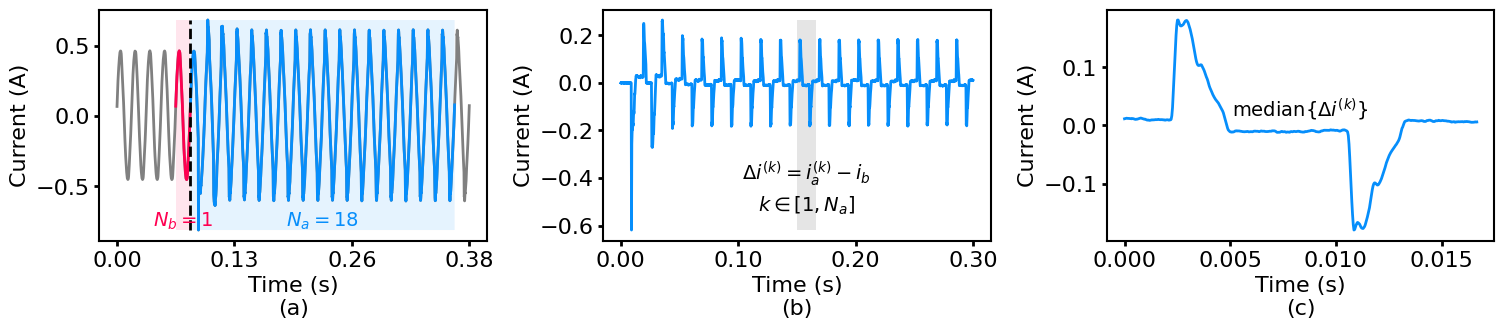

In [26]:
# x = 410
# x = 135
# x = np.random.randint(len(signatures0))
x = 179
print(x)
v, i, fs, f0, devices, locs = signatures0[x]
p = (v * i).mean(1)
T = v.shape[1]
chpts = run(p, 30, 15)

x = chpts[1]
Nb = 5
N = 18

x_ticks = np.linspace(0, 1 / 60 * (N + Nb), 4)
x_tick_positions = np.linspace((x - Nb) * i.shape[1], (x + N + 1) * i.shape[1],
                               len(x_ticks))

_, ax = plt.subplots(1, 3, figsize=(18, 3), gridspec_kw={'wspace': 0.3})

ax[0].plot(np.arange((x - Nb) * i.shape[1], (x + N + 1) * i.shape[1]),
           i[x - Nb:x + N + 1].ravel(),
           color='gray',
           linewidth=2)

i_before = i[x - 1:x]

ax[0].plot(np.arange((x - 1) * i.shape[1], x * i.shape[1]),
           i_before.ravel(),
           color='#ff0051',
           linewidth=2)

i_after = i[x:x + N]

ax[0].plot(np.arange(x * i.shape[1], (x + N) * i.shape[1]),
           i_after.ravel(),
           color='#068efb',
           linewidth=2)

ax[0].vlines(x * i.shape[1],
             i_after.min(),
             i_after.max(),
             colors='black',
             linestyles='--',
             linewidth=2)
ax[0].fill_between(np.arange((x - 1) * i.shape[1], x * i.shape[1]),
                   i_after.min(),
                   i_after.max(),
                   color='#ff0051',
                   edgecolor=None,
                   alpha=0.1)
ax[0].fill_between(np.arange(x * i.shape[1], (x + N) * i.shape[1]),
                   i_after.min(),
                   i_after.max(),
                   color='#068efb',
                   edgecolor=None,
                   alpha=0.1)
ax[0].set_xticks(x_tick_positions)
ax[0].set_xticklabels([f"{t:.2f}" for t in x_ticks])
ax[0].set_xlabel('Time (s)\n(a)', fontsize=16)
ax[0].set_ylabel('Current (A)', fontsize=16)
ax[0].tick_params(labelsize=16, width=2)
ax[0].text((x - 0.5) * i.shape[1],
           i_before.min() - 0.22,
           r'$N_b=1$',
           color='#ff0051',
           fontsize=14,
           ha='center',
           va='top')
ax[0].text((x + N / 2) * i.shape[1],
           i_before.min() - 0.22,
           r'$N_a=18$',
           color='#068efb',
           fontsize=14,
           ha='center',
           va='top')

di = i_after - i_before

x_ticks = np.linspace(0, 1 / 60 * N, 4)
x_tick_positions = np.linspace(0, N * i.shape[1], len(x_ticks))
ax[1].plot(di.ravel(), linewidth=2, color='#068efb')
ax[1].set_xticks(x_tick_positions)
ax[1].set_xticklabels([f"{t:.2f}" for t in x_ticks])
ax[1].set_xlabel('Time (s)\n(b)', fontsize=16)
ax[1].set_ylabel('Current (A)', fontsize=16)
ax[1].tick_params(labelsize=16, width=2)
ax[1].fill_between(np.arange(N // 2 * i.shape[1], (N // 2 + 1) * i.shape[1]),
                   di.min(),
                   di.max(),
                   color='black',
                   edgecolor=None,
                   alpha=0.1)
ax[1].text((N // 2 + 0.5) * i.shape[1],
           di.min() + 0.15,
           r'$k\in[1,N_a]$',
           color='black',
           fontsize=14,
           ha='center',
           va='top')
ax[1].text((N // 2 + 0.5) * i.shape[1],
           di.min() + 0.3,
           r'$\Delta i^{(k)} = i_a^{(k)}-i_b$',
           color='black',
           fontsize=14,
           ha='center',
           va='top')

ax[2].plot(np.linspace(0, 1 / 60, di.shape[1]),
           np.median(di, axis=0),
           color='#068efb',
           linewidth=2)
ax[2].text(1 / 120,
           0.05,
           r'$\text{median}\{\Delta i^{(k)}\}$',
           color='black',
           fontsize=14,
           ha='center',
           va='top')
ax[2].set_xlabel('Time (s)\n(c)', fontsize=16)
ax[2].set_ylabel('Current (A)', fontsize=16)
ax[2].tick_params(labelsize=16, width=2)

for axis in ax:
    axis.spines['top'].set_linewidth(1.5)
    axis.spines['right'].set_linewidth(1.5)
    axis.spines['bottom'].set_linewidth(1.5)
    axis.spines['left'].set_linewidth(1.5)

plt.savefig('figures/after-before.svg', bbox_inches='tight')
plt.show()

In [27]:
def get_data(signatures0, post_fn=None, Nc=15, **kwargs):
    D2 = set()
    X2 = []
    P2 = []
    y2 = []

    for v, i, fs, f0, devices, locs in tqdm(signatures0):
        p = (v * i).mean(1)
        T = v.shape[1]
        chpts = run(p, 20, 15)
        D2 |= set(devices)

        for x in chpts:
            i_before = i[x - 1:x]
            v_before = v[x - 1]

            if post_fn is not None:
                i_after = i[x:x + Nc]
            else:
                i_after = i[x:x + 1]

            di = i_after - i_before

            # di = np.median(di, axis=0, keepdims=True)
            if post_fn is not None:
                di = post_fn(di, **kwargs)
                # di = di[1, None]

            off = i_after.std() < i_before.std()

            if off:
                di = -di

            label = -1
            epsilon = T - 1

            x *= T

            for dev_idx, (start, end) in enumerate(locs):
                if abs(x - start) <= epsilon or abs(x - end) <= epsilon:
                    label = devices[dev_idx]
                    break

            X2.append(di), y2.append(label)
            P2.append((di * v_before).mean(keepdims=True))

    X2 = np.concatenate(X2)
    P2 = np.concatenate(P2)
    y2 = np.stack(y2)

    D2 = sorted(D2)

    D2 = np.unique(y2)
    D = set(D1) & set(D2)
    D = sorted(D)

    mask = np.isin(y2, D)
    X2 = X2[mask]
    P2 = P2[mask]
    y2 = y2[mask]
    y2 = enc.transform(y2)

    Zh = np.fft.rfft(X2, axis=1, norm='forward')
    amplitudes = np.abs(Zh)
    phases = np.angle(Zh)
    print(P2.shape, X2.shape)
    X2h = np.concatenate(
        (
            amplitudes[:, :n_a_low],
            # np.sin(phases[:, 1:n_low]),
            np.cos(phases[:, 1:n_low]),
            np.cos(phases[:, 1:n_low]).mean(1, keepdims=True),
        ),
        axis=-1)

    return X2, X2h, y2, D

In [28]:
feature_names = np.asarray([
    *[fr'$a_{i}$' for i in range(n_a_low)],
    # *[f'sin_ph_{i}' for i in range(1, n_low)],
    *[fr'$\cos\phi_{i}$' for i in range(1, n_low)],
    r'$\text{mean}' + r'(\cos\phi_{>' + f'{n_low}' + r'})$'
])
feature_names

array(['$a_0$', '$a_1$', '$\\cos\\phi_1$', '$\\cos\\phi_2$',
       '$\\cos\\phi_3$', '$\\cos\\phi_4$', '$\\cos\\phi_5$',
       '$\\cos\\phi_6$', '$\\cos\\phi_7$', '$\\cos\\phi_8$',
       '$\\cos\\phi_9$', '$\\cos\\phi_10$',
       '$\\text{mean}(\\cos\\phi_{>11})$'], dtype='<U29')

In [29]:
X1h.shape

(164510, 13)

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit, train_test_split
from xgboost import XGBClassifier
import numpy as np

# # Define the model
# m3 = XGBClassifier(
#     random_state=42,
#     #    **{
#     #        'subsample': 0.9,
#     #        'reg_lambda': 0.01,
#     #        'reg_alpha': 0.001,
#     #        'n_estimators': 150,
#     #        'max_depth': 7,
#     #        'learning_rate': 0.46415888336127775,
#     #        'gamma': 0.0,
#     #        'colsample_bytree': 0.7
#     #    })
# )

# # m3.fit(X1h, y1)
# # mask = m3.feature_importances_ > 0.01
# # m3.fit(X1h[:, mask], y1)
# # X_train, X_val, y_train, y_val = train_test_split(X1h, y1, test_size=0.2, stratify=y1, random_state=42)
# X2h, y2, D = get_data(signatures0, np.median, axis=0, keepdims=True)
# val = np.zeros(len(y1) + len(y2))
# val[:len(y1)] = -1

# # Define the parameter grid for random search
# param_distributions = {
#     'n_estimators': np.arange(50, 300, 50),  # Number of trees
#     'max_depth': np.arange(3, 10),  # Maximum tree depth
#     'learning_rate': np.logspace(-3, 0, 10),  # Learning rate
#     'subsample': np.linspace(0.6, 1.0,
#                              5),  # Fraction of samples used for training
#     'colsample_bytree': np.linspace(0.6, 1.0,
#                                     5),  # Fraction of features used per tree
#     'gamma': np.linspace(0, 5, 5),  # Regularization term
#     'reg_alpha': np.logspace(-3, 1, 5),  # L1 regularization
#     'reg_lambda': np.logspace(-3, 1, 5)  # L2 regularization
# }

# # Set up RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=m3,
#     param_distributions=param_distributions,
#     n_iter=50,
#     scoring='accuracy',
#     cv=PredefinedSplit(val),
#     verbose=999,
#     random_state=42,
#     n_jobs=-1  # Use all available cores
# )

# # Fit the random search
# random_search.fit(np.concatenate((X1h, X2h)), np.concatenate((y1, y2)))

# # Best parameters and score
# print("Best parameters found: ", random_search.best_params_)
# print("Best cross-validated accuracy: ", random_search.best_score_)
# m3 = random_search.best_estimator_

m3 = XGBClassifier(
    {
        'subsample': 0.6,
        'reg_lambda': 0.01,
        'reg_alpha': 10.0,
        'n_estimators': 200,
        'max_depth': 8,
        'learning_rate': 0.046415888336127774,
        'gamma': 3.75,
        'colsample_bytree': 0.6
    },
    random_state=42,
    n_jobs=12)
m3.fit(X1h, y1)
mask = m3.feature_importances_ > 0.01
m3.fit(X1h[:, mask], y1)

# mask[4] = False
# m3.fit(X1h[:, mask], y1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=12,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [184]:
from sklearn.metrics import precision_score, recall_score, f1_score

# m5 = LogisticRegression('elasticnet',
#                         l1_ratio=0.1,
#                         max_iter=5000,
#                         solver='saga',
#                         random_state=42)
# m5.fit(X1h[:, mask], y1)
# y5 = m5.predict(X2h[:, mask])

accuracy_score(y2, y5), precision_score(y2, y5, average='macro'), recall_score(
    y2, y5, average='macro'), f1_score(y2, y5, average='macro')

(0.8001704303366, 0.8087817554292186, 0.8019120853486498, 0.7997473349749842)

In [188]:
m4 = DecisionTreeClassifier(random_state=42)
m4.fit(X1h[:, mask], y1)
y4 = m4.predict(X2h[:, mask])

accuracy_score(y2, y4), precision_score(y2, y4, average='macro'), recall_score(
    y2, y4, average='macro'), f1_score(y2, y4, average='macro')

(0.8351086493395824,
 0.8490621103439296,
 0.8631752008434502,
 0.8392784037936944)

In [307]:
for i in range(len(D)):
    msk = y2 == i
    ac = accuracy_score(y2[msk], y3[msk])
    if ac < 0.9:
        print(D[i], ac)

incandescent_light_bulb 0.8743961352657005
iron_solder 0.5547169811320755


In [228]:
from sklearn.metrics import jaccard_score, f1_score

acc = []
Ncs = list(range(1, 30))

for Nc in Ncs:
    X2h, y2, D = get_data(signatures0, np.median, axis=0, keepdims=True, Nc=Nc)
    y3 = m3.predict(X2h[:, mask])
    acc.append(accuracy_score(y2, y3))

# , precision_score(y2, y3, average='macro'), recall_score(
# y2, y3, average='macro'), f1_score(y2, y3, average='macro')

100%|██████████| 575/575 [00:00<00:00, 1528.61it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 1406.84it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 1404.23it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 1341.74it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 1321.70it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 1247.81it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 1267.61it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 1267.79it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 1305.12it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 1231.86it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 1209.19it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 1151.99it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 1147.13it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 1046.26it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 1099.17it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 1045.64it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 1025.63it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 980.20it/s] 


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 974.95it/s] 


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 970.13it/s] 


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 937.68it/s] 


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 923.90it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 911.84it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 861.45it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 857.83it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 823.28it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 822.46it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 822.22it/s]


(2347, 1) (2347, 500)


100%|██████████| 575/575 [00:00<00:00, 809.53it/s]

(2347, 1) (2347, 500)


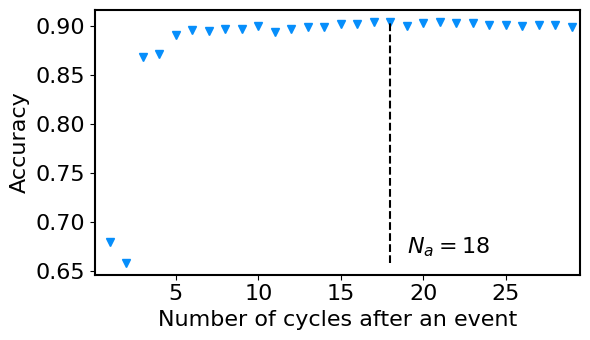

In [319]:
plt.figure(figsize=(6, 3.5))
disp = plt.plot(Ncs, acc, 'v', color='#068efb')
plt.vlines(Ncs[np.argmax(acc)],
           min(acc),
           max(acc),
           colors='black',
           linestyles='--')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.text(Ncs[np.argmax(acc)] + 1,
         0.01 + min(acc),
         fr'$N_a={Ncs[np.argmax(acc)]}$',
         fontsize=16)

for spine in disp[0].axes.spines.values():
    spine.set_linewidth(1.5)

plt.xlim([0.1, max(Ncs) + 0.5])
plt.xlabel('Number of cycles after an event', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.tight_layout()
plt.savefig('figures/n-after.svg', bbox_inches='tight')
plt.show()

In [210]:
X2, X2h, y2, D = get_data(signatures0,
                      np.median,
                      axis=0,
                      keepdims=True,
                    #   Nc=Ncs[np.argmax(acc)])
                      Nc=18)
y3 = m3.predict(X2h[:, mask])

accuracy_score(y2, y3), precision_score(y2, y3, average='macro'), recall_score(
    y2, y3, average='macro'), f1_score(y2, y3, average='macro')

100%|██████████| 575/575 [00:00<00:00, 933.37it/s] 


(2347, 1) (2347, 500)


NameError: name 'precision_score' is not defined

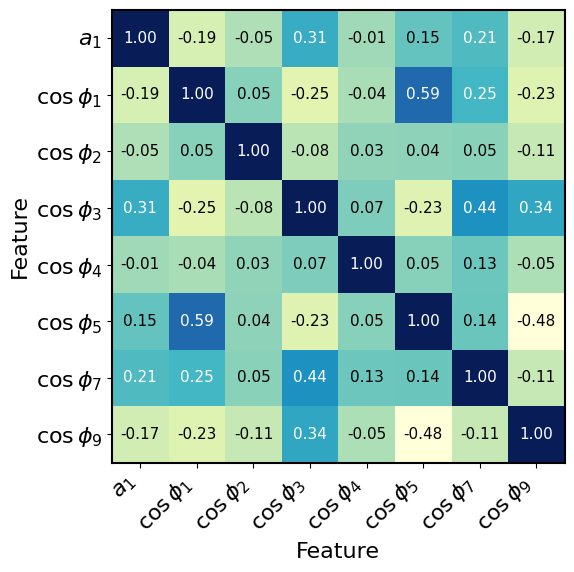

In [212]:
import numpy as np
import matplotlib.pyplot as plt

# Filter features and calculate correlation matrix
filtered_feature_names = feature_names[mask]
C = np.corrcoef(X2h[:, mask], rowvar=False)

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
disp = plt.imshow(C, cmap='YlGnBu', interpolation='nearest')
# plt.colorbar(label='Correlation Coefficient')

# Add feature names as labels
plt.xticks(ticks=np.arange(len(filtered_feature_names)),
           labels=filtered_feature_names,
           rotation=45,
           ha='right',
           fontsize=16)
plt.yticks(ticks=np.arange(len(filtered_feature_names)),
           labels=filtered_feature_names,
           fontsize=16)

# Add text annotations with contrast adjustment
for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        text_color = "white" if C[
            i, j] > 0.2 else "black"  # Adjust text color for contrast
        plt.text(j,
                 i,
                 f"{C[i, j]:.2f}",
                 ha='center',
                 va='center',
                 color=text_color,
                 fontsize=11)

disp.axes.set_xlabel("Feature", fontsize=16)
disp.axes.set_ylabel("Feature", fontsize=16)

for spine in disp.axes.spines.values():
    spine.set_linewidth(1.5)

# plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig('figures/feature-corr.svg', bbox_inches='tight')
plt.show()

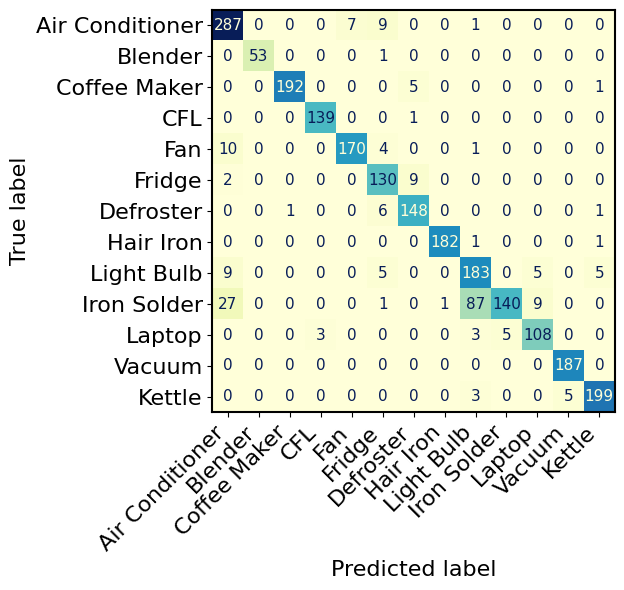

In [294]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_true_labs = np.asarray(D)[y2]
y_pred_labs = np.asarray(D)[y_pred]

display_labels = [
    'Air Conditioner', 'Blender', 'Coffee Maker', 'CFL', 'Fan', 'Fridge',
    'Defroster', 'Hair Iron', 'Light Bulb', 'Iron Solder', 'Laptop', 'Vacuum',
    'Kettle'
]

disp = ConfusionMatrixDisplay.from_predictions(y_true_labs,
                                               y_pred_labs,
                                               display_labels=display_labels,
                                               cmap='YlGnBu',
                                               colorbar=False)

disp.figure_.set_size_inches(8, 6)
plt.setp(disp.ax_.get_xticklabels(), rotation=45, ha="right", fontsize=16)
plt.setp(disp.ax_.get_yticklabels(), fontsize=16)

disp.ax_.set_xlabel("Predicted label", fontsize=16)
disp.ax_.set_ylabel("True label", fontsize=16)

for spine in disp.ax_.spines.values():
    spine.set_linewidth(1.5)

for text in disp.text_.ravel():
    text.set_fontsize(11)

plt.tight_layout()
plt.savefig('figures/confusion.svg', bbox_inches='tight')
plt.show()

In [49]:
# import numpy as np
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# X_train, X_val, y_train, y_val = train_test_split(X1h[:, feature_mask],
#                                                   y1,
#                                                   test_size=0.1,
#                                                   random_state=42,
#                                                   stratify=y1)

# param_grid = {
#     'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100],
#     'l1_ratio': [0.0, 0.1, 0.5, 0.7, 0.9, 1.0],
# }

# model = LogisticRegression(penalty='elasticnet',
#                            solver='saga',
#                            max_iter=5000,
#                            n_jobs=12)

# grid_search = RandomizedSearchCV(estimator=model,
#                                  param_distributions=param_grid,
#                                  scoring='accuracy',
#                                  cv=5,
#                                  n_jobs=-1,
#                                  verbose=999)

# grid_search.fit(X_train, y_train)

# print("Best parameters found by GridSearchCV:")
# print(grid_search.best_params_)

# best_model = grid_search.best_estimator_
# y_pred_val = best_model.predict(X_val)
# val_accuracy = accuracy_score(y_val, y_pred_val)
# print(f"Validation Accuracy: {val_accuracy:.4f}")

In [116]:
# display_labels = {
#     'air_conditioner': 'Air Conditioner',
#     'blender': 'Blender',
#     'coffee_maker': 'Coffee Maker',
#     'compact_fluorescent_lamp': 'CFL',
#     'fan': 'Fan',
#     'fridge': 'Fridge',
#     'fridge_defroster': 'Defroster',
#     'hair_iron': 'Hair Iron',
#     'incandescent_light_bulb': 'Light Bulb',
#     'iron_solder': 'Iron Solder',
#     'laptop': 'Laptop',
#     'vacuum': 'Vacuum',
#     'water_kettle': 'Kettle'
# }

In [117]:
list(set(y2))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

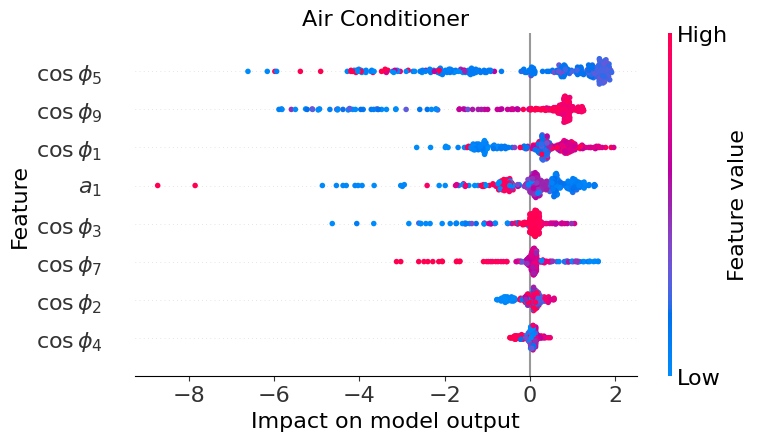

In [213]:
import shap

cls = 0
subset = y2 == cls
print(subset.sum())
explainer = shap.TreeExplainer(m3, X2h[subset][:, mask])
sv = explainer(X2h[subset][:, mask])

plt.figure(figsize=(12, 8))
# Update font size for all labels, ticks, and colorbar ticks
plt.rcParams.update({
    'font.size': 16,  # Global font size
    'xtick.labelsize': 16,  # X-axis tick labels
    'ytick.labelsize': 16,  # Y-axis tick labels
})

# Generate the SHAP summary plot
shap_figure = shap.summary_plot(sv[:, :, cls],
                                X2h[subset][:, mask],
                                feature_names=feature_names[mask],
                                show=False)

# Adjust axes labels
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('Impact on model output', fontsize=16)
ax.set_ylabel('Feature', fontsize=16)

# Adjust colorbar title and ticks font size
colorbar = fig.axes[-1]  # The colorbar axis is usually the last in the figure
colorbar.tick_params(labelsize=16)  # Adjust tick labels
colorbar.set_ylabel('Feature value',
                    fontsize=16)  # Set the label for the colorbar

# Adjust feature name font size manually
for text in ax.get_yticklabels():
    text.set_fontsize(16)

for text in ax.get_xticklabels():
    text.set_fontsize(16)

# Add title and save the plot
plt.title(display_labels[cls], fontsize=16)
plt.tight_layout()
plt.savefig('figures/shap.svg', format='svg', bbox_inches='tight')
plt.show()